In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier

import keras
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout



In [3]:
df = pd.read_csv("../ground_amplitude.csv")
df = df.dropna()
""" df = df.drop_duplicates()"""
df = df[df['processo_ocorrencia'] != 'Desabamento Parcial Imoveis']  # Esses tipos de ocorrência prejudicava o recall 
df = df[df['processo_ocorrencia'] != 'Muro com Danos']
df = df[df['processo_ocorrencia']!= 'Imoveis com Danos/Risco'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2459 entries, 2 to 5121
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   processo_numero         2459 non-null   object 
 1   solicitacao_data        2459 non-null   object 
 2   solicitacao_hora        2459 non-null   object 
 3   solicitacao_descricao   2459 non-null   object 
 4   solicitacao_bairro      2459 non-null   object 
 5   solicitacao_localidade  2459 non-null   object 
 6   solicitacao_endereco    2459 non-null   object 
 7   processo_ocorrencia     2459 non-null   object 
 8   confirmado              2459 non-null   int64  
 9   latitude                2459 non-null   float64
 10  longitude               2459 non-null   float64
 11  cond                    2459 non-null   bool   
 12  em_recife               2459 non-null   int64  
 13  rain_hour               2459 non-null   float64
 14  rain_day                2459 non-null   

In [4]:
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
y = df['confirmado']
X = df[['altitude', 'rain_day', 'rain_hour', 'ground_type', 'danger_level', 'ground_amplitude', 'flooding_risk']]


In [6]:
# work with labels
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)


dummy_y = np_utils.to_categorical(encoded_y)

encoder.fit(X['danger_level'])
X['danger_level'] = encoder.transform(X['danger_level'])

encoder.fit(X['ground_type'])
X['ground_type'] = encoder.transform(X['ground_type'])
encoder.fit(X['flooding_risk'])
X['flooding_risk'] = encoder.transform(X['flooding_risk'])
encoder.fit(X['ground_amplitude'])
X['ground_amplitude'] = encoder.transform(X['ground_amplitude'])

print(y.head(7), encoded_y[6])
y.unique()



0    1
1    0
2    1
3    1
4    1
5    1
6    0
Name: confirmado, dtype: int64 0


C:\Users\parae\AppData\Local\Temp\ipykernel_13636\4033383670.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['danger_level'] = encoder.transform(X['danger_level'])
C:\Users\parae\AppData\Local\Temp\ipykernel_13636\4033383670.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ground_type'] = encoder.transform(X['ground_type'])
C:\Users\parae\AppData\Local\Temp\ipykernel_13636\4033383670.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

array([1, 0], dtype=int64)

In [7]:
X = np.array(X)



model = Sequential()
model.add(Dropout(0.3))
model.add(Dense(256, input_shape=(X.shape[1],), activation='relu')) # input shape is (features,)
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', # this is different instead of binary_crossentropy (for regular classification)
              metrics=['accuracy'])

#model.summary()
X.shape[1]

7

In [8]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=20, 
                                   restore_best_weights=True)




history = model.fit(X,
                    dummy_y,
                    callbacks=[es],
                    epochs=8000000, # you can set this to a big number!
                    batch_size=20,
                    shuffle=True,
                    validation_split=0.3,
                    verbose=1)


Epoch 1/8000000
87/87 [==============================] - 2s 7ms/step - loss: 1.4177 - accuracy: 0.5282 - val_loss: 0.8205 - val_accuracy: 0.6003
Epoch 2/8000000
87/87 [==============================] - 0s 4ms/step - loss: 1.1369 - accuracy: 0.5543 - val_loss: 0.7571 - val_accuracy: 0.5596
Epoch 3/8000000
87/87 [==============================] - 0s 3ms/step - loss: 1.0915 - accuracy: 0.5474 - val_loss: 0.6698 - val_accuracy: 0.6192
Epoch 4/8000000
87/87 [==============================] - 0s 3ms/step - loss: 0.9369 - accuracy: 0.5811 - val_loss: 0.7006 - val_accuracy: 0.6287
Epoch 5/8000000
87/87 [==============================] - 0s 4ms/step - loss: 0.8829 - accuracy: 0.5805 - val_loss: 0.6519 - val_accuracy: 0.6328
Epoch 6/8000000
87/87 [==============================] - 0s 3ms/step - loss: 0.8654 - accuracy: 0.5816 - val_loss: 0.6375 - val_accuracy: 0.6409
Epoch 7/8000000
87/87 [==============================] - 0s 4ms/step - loss: 0.7935 - accuracy: 0.5880 - val_loss: 0.6477 - val_ac

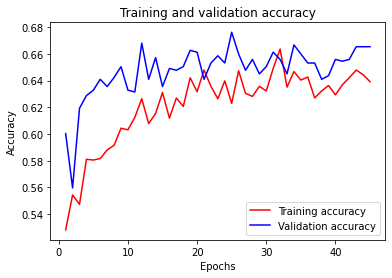

In [9]:
import matplotlib.pyplot as plt

history_dict = history.history

# learning curve
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

preds = model.predict(X) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1
## [9.9999988e-01 1.3509347e-07 6.7064638e-16]
## 1.0

# Almost a perfect prediction
# actual is left, predicted is top
# names can be found by inspecting Y
matrix = confusion_matrix(dummy_y.argmax(axis=1), preds.argmax(axis=1))
print(matrix)



# more detail on how well things were predicted
print(classification_report(dummy_y.argmax(axis=1), preds.argmax(axis=1)))



77/77 [==============================] - 0s 2ms/step
[0.48832658 0.5116734 ]
1.0
[[ 474  549]
 [ 259 1177]]
              precision    recall  f1-score   support

           0       0.65      0.46      0.54      1023
           1       0.68      0.82      0.74      1436

    accuracy                           0.67      2459
   macro avg       0.66      0.64      0.64      2459
weighted avg       0.67      0.67      0.66      2459



In [11]:
print(model.predict(X))
model.evaluate(X, dummy_y)
dummy_y

77/77 [==============================] - 0s 2ms/step
[[0.48832658 0.5116734 ]
 [0.45509535 0.54490465]
 [0.34125856 0.65874153]
 ...
 [0.18005605 0.81994396]
 [0.4062533  0.5937467 ]
 [0.19488539 0.8051147 ]]
77/77 [==============================] - 0s 2ms/step - loss: 0.6198 - accuracy: 0.6714


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)